## packages

In [1]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
#layer for nlayers conv2 for 2D convolutionsl layer  input for input layer flatten for converting to 1d
import tensorflow as tf

In [3]:
#Model(inputs=[inputimage,verificationimage], outputs=[0,1])

## only if you have gpu i don't 😒

'''
 before using this code install the tensorflow-gpu dependency
 gpus = tf.config.experimental.list_physical_devices('GPU') 
 for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)
'''


## Setting up paths

ok so here in case of siamese nn it's a type of convolutional nn but in this 
before output layers we will have distance layer which calculate a similarity score between the embeddings of two input items
we are gonna pass two image one as anchor image and a positive image(which has to be verify)
and then it will gonna give us output as positive and negative(basically it is that image
or not) so for this anchor and positive image in learning time we will have different folders

In [4]:
# setting up paths
pos_path =os.path.join('data','positive') 
neg_path =os.path.join('data','negative') 
anch_path =os.path.join('data','anchor') 

In [5]:
#creating the derectories
'''os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anch_path)'''

'os.makedirs(pos_path)\nos.makedirs(neg_path)\nos.makedirs(anch_path)'

## collecting data like anchor images and positive

First Collecting labelled faces in the wild Dataset

In [6]:
# http://vis-www.cs.umass.eduxLfw/

In [7]:
#moving all the images into the negative folder
'''for directory in os.listdir('lfw'): 
 for file in os.listdir(os.path.join('lfw',directory)):
  EX_PATH = os.path.join('lfw',directory,file)
  NEW_PATH= os.path.join(neg_path,file)
  os.replace(EX_PATH,NEW_PATH)'''

"for directory in os.listdir('lfw'): \n for file in os.listdir(os.path.join('lfw',directory)):\n  EX_PATH = os.path.join('lfw',directory,file)\n  NEW_PATH= os.path.join(neg_path,file)\n  os.replace(EX_PATH,NEW_PATH)"

##  Collecting positive and anchor classes

In [8]:
# importing uuid to generates unique image names
import uuid

In [9]:
uuid.uuid1()

UUID('fabc75be-3865-11f0-ae6f-be6656f4d938')

In [10]:
#connection to the webcam
cap=cv2.VideoCapture(1)
while cap.isOpened():
    ret,frame= cap.read()
    frame= frame[120:120+250,200:200+250,:]
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname =os.path.join(anch_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname =os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)           
#show image back to screen    
    cv2.imshow('image collector',frame)
#breaking gracefully        
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#release the webcam        
cap.release()    
#close the image show frame
cv2.destroyAllWindows()

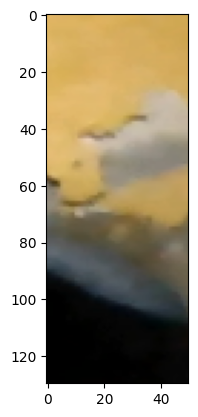

In [11]:
plt.imshow(frame[120:120+250,200:200+250,:])

## bringing images from files or get image directories into ram maybe

In [12]:
anchor = tf.data.Dataset.list_files(anch_path+'/*jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'/*jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'/*jpg').take(300)

## preprocessing scale and resize

In [13]:
def preprocess(file_path):
    #read the image
    byte_img = tf.io.read_file(file_path)
    #loading the image
    img = tf.io.decode_jpeg(byte_img)
    #resizing the image to be 100*100*3
    img = tf.image.resize(img,(100,100))
    #scalling the image to be between 1 and 0
    img = img/255.0
    return img

In [14]:
#dataset.map(preprocess)

## create labelled data

In [15]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
exampple = samples.next()

In [19]:
exampple

(b'data\\anchor\\35a95035-3864-11f0-a54a-be6656f4d938.jpg',
 b'data\\positive\\3a342f4b-3864-11f0-b8e3-be6656f4d938.jpg',
 np.float32(1.0))

## build train and test spllinting datasets

In [20]:
def preprocess_twin(input_img, validation_img, label):
    #here input = trying to verify and validation which is the verified img and label is label
    return(preprocess(input_img), preprocess(validation_img), label)

In [21]:
res = preprocess_twin(*exampple)
#this will have 3 objects in in it

In [1]:
#plt.imshow(res[1])

In [23]:
#so that's the label
res[2]

np.float32(1.0)

In [24]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [25]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition
#here we are taking 70% for training the model
test_data = data.skip(round(len(data)*.7))
#here 30% for testing the data
test_data = test_data.take(round(len(data)*.3))
# 16 images in batch means 16 images in each value or object
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## model Engineering - Deep learning stuff

## build embedding layer

In [27]:
# Convolution ----> Relu -----> Max Pooling till the output layer
inp = Input(shape=(100,100,3), name='input_image')

In [28]:
# here our input shape is 100*100 but in siamese nn topic it had 105 which was diff but completely fine 
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [29]:
# take the maximum value or the object we really want
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [30]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [31]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [32]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
# flatten will just give you a single dimension array
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [33]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [34]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [36]:
embedding = make_embedding()

In [37]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## build distance layer

In [38]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [39]:
l1 = L1Dist()

In [40]:
#l1(anchor_embedding, validation_embedding)

## build siamese model

In [41]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [42]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [43]:
siamese_layer = L1Dist()

In [44]:
distances = siamese_layer(inp_embedding,val_embedding)

In [45]:
classifier =Dense(1,activation='sigmoid')(distances)

In [46]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>

In [47]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [48]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    


In [50]:
siamese_model = make_siamese_model()

In [51]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training

setup loss and optimizer

In [52]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [53]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001 learning rate

Establish checkpoints

In [54]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Build train Step Function

In [55]:
test_batch = train_data.as_numpy_iterator()
test_batch.next()

(array([[[[3.01960796e-01, 6.47058845e-01, 7.88235307e-01],
          [3.09803933e-01, 6.43137276e-01, 7.90196061e-01],
          [3.15686285e-01, 6.43137276e-01, 7.99019635e-01],
          ...,
          [2.49754906e-01, 5.33088207e-01, 6.63480401e-01],
          [2.60784328e-01, 5.35294116e-01, 6.68627441e-01],
          [2.66666681e-01, 5.33333361e-01, 6.70588255e-01]],
 
         [[3.10784310e-01, 6.44117653e-01, 7.89215684e-01],
          [3.15931380e-01, 6.47303939e-01, 7.95343161e-01],
          [3.24019611e-01, 6.48774505e-01, 8.05637240e-01],
          ...,
          [2.56862760e-01, 5.43137252e-01, 6.78921580e-01],
          [2.60539204e-01, 5.40196061e-01, 6.73774481e-01],
          [2.60784328e-01, 5.38235307e-01, 6.72549009e-01]],
 
         [[3.34313720e-01, 6.67647064e-01, 8.18627477e-01],
          [3.38480383e-01, 6.65441155e-01, 8.20098042e-01],
          [3.42892170e-01, 6.65441155e-01, 8.22303951e-01],
          ...,
          [2.60784328e-01, 5.50000012e-01, 6.8725

In [56]:
batch_1 = test_batch.next()

In [57]:
X = batch_1[:2]
# Each batch contains 16 images

In [58]:
y = batch_1[2]

In [59]:
y

array([0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [60]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [61]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

Build training loop

In [62]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [63]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

Train the model

In [64]:
EPOCHS = 50

In [65]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422

## Evaluate Model

Imort Metrics

In [66]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

Make Predictions

In [67]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [68]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


In [69]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0]

In [70]:
y_true

array([1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.],
      dtype=float32)

Calculate Matrics

In [71]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [72]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [73]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1.0 1.0


## Viz Result

In [3]:
# Set plot size 
#plt.figure(figsize=(10,8))

# Set first subplot
#plt.subplot(1,2,1)
#plt.imshow(test_input[0])

# Set second subplot
#plt.subplot(1,2,2)
#plt.imshow(test_val[0])

# Renders cleanly
#plt.show()

## Save Model

In [75]:
# Save weights
siamese_model.save('mymodel.h5')

In [76]:
L1Dist

__main__.L1Dist

In [77]:
# Reload model 
siamese_model = tf.keras.models.load_model('mymodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [78]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


array([[1.6965987e-06],
       [7.2383040e-07],
       [4.7153586e-07],
       [1.0000000e+00]], dtype=float32)

In [79]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Real Time test

 Verification Function

application_data\verification_images

In [80]:
os.listdir(os.path.join('application_data', 'verification_images'))

['13ad6c54-1f9d-11f0-9545-efebc3d63619.jpg',
 '13c24cc3-1f9d-11f0-8650-efebc3d63619.jpg',
 '3be01ffd-1f9e-11f0-a522-efebc3d63619.jpg',
 '3bf061f7-2034-11f0-9acd-c00f8a703b86.jpg',
 '3c16f85c-2034-11f0-a3c9-c00f8a703b86.jpg',
 '3c6400f9-2034-11f0-a154-c00f8a703b86.jpg',
 '3c8e7592-2034-11f0-8357-c00f8a703b86.jpg',
 '3ca61492-2034-11f0-ba30-c00f8a703b86.jpg',
 '3caca0b9-2034-11f0-8ec7-c00f8a703b86.jpg',
 '3cb4a25a-2034-11f0-aafd-c00f8a703b86.jpg',
 '3cba7a55-2034-11f0-94d2-c00f8a703b86.jpg',
 '3cc06a2b-2034-11f0-b5df-c00f8a703b86.jpg',
 '3ce300fc-2034-11f0-a659-c00f8a703b86.jpg',
 '3ce8cee3-2034-11f0-922a-c00f8a703b86.jpg',
 '8dc3b228-1f9e-11f0-b712-efebc3d63619.jpg',
 '8def15cf-1f9e-11f0-b4eb-efebc3d63619.jpg',
 '8df4d676-1f9e-11f0-b082-efebc3d63619.jpg',
 '9e53400e-1f9e-11f0-948b-efebc3d63619.jpg',
 '9e58f84f-1f9e-11f0-ab89-efebc3d63619.jpg',
 '9eb6ff94-1f9e-11f0-a4cb-efebc3d63619.jpg',
 '9ebcb741-1f9e-11f0-bca5-efebc3d63619.jpg',
 '9f038fdb-1f9e-11f0-a420-efebc3d63619.jpg',
 '9f0935a8

In [81]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [82]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\13ad6c54-1f9d-11f0-9545-efebc3d63619.jpg
application_data\verification_images\13c24cc3-1f9d-11f0-8650-efebc3d63619.jpg
application_data\verification_images\3be01ffd-1f9e-11f0-a522-efebc3d63619.jpg
application_data\verification_images\3bf061f7-2034-11f0-9acd-c00f8a703b86.jpg
application_data\verification_images\3c16f85c-2034-11f0-a3c9-c00f8a703b86.jpg
application_data\verification_images\3c6400f9-2034-11f0-a154-c00f8a703b86.jpg
application_data\verification_images\3c8e7592-2034-11f0-8357-c00f8a703b86.jpg
application_data\verification_images\3ca61492-2034-11f0-ba30-c00f8a703b86.jpg
application_data\verification_images\3caca0b9-2034-11f0-8ec7-c00f8a703b86.jpg
application_data\verification_images\3cb4a25a-2034-11f0-aafd-c00f8a703b86.jpg
application_data\verification_images\3cba7a55-2034-11f0-94d2-c00f8a703b86.jpg
application_data\verification_images\3cc06a2b-2034-11f0-b5df-c00f8a703b86.jpg
application_data\verification_images\3ce300fc-2034-11f0-a659-c00

In [83]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        # preprocess from wayback in time above
        #and yes we are storing image from our webcam into input image file
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

Open CV Real Time Verification

In [84]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

In [85]:
np.sum(np.squeeze(results) > 0.9)

np.int64(28)

In [86]:
results

[array([[0.77232796]], dtype=float32),
 array([[0.62122536]], dtype=float32),
 array([[0.7141465]], dtype=float32),
 array([[0.98218656]], dtype=float32),
 array([[0.98343086]], dtype=float32),
 array([[0.9997842]], dtype=float32),
 array([[0.9999563]], dtype=float32),
 array([[0.9994579]], dtype=float32),
 array([[0.9994579]], dtype=float32),
 array([[0.99979687]], dtype=float32),
 array([[0.99979687]], dtype=float32),
 array([[0.99979687]], dtype=float32),
 array([[0.9986187]], dtype=float32),
 array([[0.9986187]], dtype=float32),
 array([[0.91264844]], dtype=float32),
 array([[0.8400063]], dtype=float32),
 array([[0.8400063]], dtype=float32),
 array([[0.98619246]], dtype=float32),
 array([[0.9346255]], dtype=float32),
 array([[0.9804688]], dtype=float32),
 array([[0.9804688]], dtype=float32),
 array([[0.9896626]], dtype=float32),
 array([[0.9896626]], dtype=float32),
 array([[0.92634165]], dtype=float32),
 array([[0.92634165]], dtype=float32),
 array([[0.97782135]], dtype=float32),
